In [8]:
import os
import numpy as np
import xarray as xr
from tqdm import tqdm
import scipy.io as sio
import matplotlib.pyplot as plt
from tqdm import tqdm
def create_2d_gabor(img_size, sigma, f, theta, phi, center_x, center_y):
    """
    Create a 2D Gabor filter.

    Parameters:
    - img_size: Size of the output Gabor filter (square).
    - sigma: Standard deviation of the Gaussian envelope.
    - gamma: Aspect ratio that controls the ellipticity of the Gaussian envelope.
    - f: Spatial frequency of the cosine factor.
    - theta: Orientation of the Gabor filter in radians.
    - phi: Phase offset.

    Returns:
    - gabor_filter: 2D Gabor filter of the specified parameters.
    """

    x = np.linspace(-img_size // 2, img_size // 2, img_size) - center_x
    y = np.linspace(-img_size // 2, img_size // 2, img_size) - center_y
    x, y = np.meshgrid(x, y) 

    x_theta = x * np.cos(theta) + y * np.sin(theta)
    y_theta = -x * np.sin(theta) + y * np.cos(theta)

    gabor_real = np.exp(-0.5 * (x_theta**2 + y_theta**2) / (sigma**2)) * np.cos(2 * np.pi * f * x_theta + phi)

    return gabor_real
def hat_snr(x):
    #x is a 2d array of shape (n_rep, n_stim, ...)
    n_rep, n_stim = x.shape[:2]
    noise_var = np.mean(np.var(x, 0, ddof=1), 0)
    sig_var = np.var(np.mean(x, 0), 0, ddof=0)
    snr = sig_var/noise_var#raw SNR estimate
    snr_corr = (sig_var - ((n_stim-1)/n_stim)*noise_var/n_rep)/noise_var #SNR estimate corrected for finite number of trials
    return snr, snr_corr

def noise_corr_R2(X, Y,):
    #y is repeat x neuron x observation
    #x is observation x feature
    K, M, N = Y.shape
    M, D = X.shape

    Y_m = (Y.mean(0) - Y.mean((0,1))).squeeze()
    hat_beta = np.linalg.lstsq(X, Y_m, rcond=None)[0]#regression of PCs of images on single units
    hat_r = X @ hat_beta#predicted responses from linear transform of images
    rss = ((Y_m - hat_r)**2).sum(0)/(M-D)#residual sum of squares
    var_r = Y_m.var(0, ddof=1) #estimate total variance of responses
    linear_var = var_r - rss #estimate of linear variance by subtracting residual variance from total variance
    S_var = (var_r - Y.var(0, ddof=1,).mean(0)/K)#signal variance
    return linear_var / S_var, linear_var / var_r

def get_beta(X, Y):
    #y is repeat x neuron x observation
    #x is observation x feature
    Y_m = (Y.mean(0) - Y.mean((0,1))).squeeze()
    hat_beta = np.linalg.lstsq(X, Y_m, rcond=None)[0]#regression of PCs of images on single units
    return hat_beta

data_dir = '/Volumes/dean_data/neural_data/stringer_2019/'
orig_data_dir = data_dir + 'orig_stringer2019_data/'
resp_data_dir = data_dir + 'processed_data/neural_responses/'
eig_tuning_dir = data_dir + 'processed_data/eig_tuning/'

fns = [resp_data_dir + fn for fn in os.listdir(resp_data_dir) if 'natimg2800_M' in fn and not 'npy' in fn and 'ms' in fn]
rf_pos_labs = {'ms_natimg2800_M160825_MP027_2016-12-14':[30, 90],
 'ms_natimg2800_M161025_MP030_2017-05-29':[90, 150],
 'ms_natimg2800_M170604_MP031_2017-06-28':[90, 150],
 'ms_natimg2800_M170714_MP032_2017-08-07':[30, 90],
 'ms_natimg2800_M170714_MP032_2017-09-14':[90, 150],
 'ms_natimg2800_M170717_MP033_2017-08-20':[90, 150],
 'ms_natimg2800_M170717_MP034_2017-09-11':[90, 150]}#figured out where to cut off RF by eye

In [2]:
sub_sample = 1
rec = 0
da = xr.open_dataset(fns[rec])
fn = fns[rec].split('/')[-1].split('.')[0]
#now load the saved u_r_stim to get the linearity of the eigenmodes
u_r_stim = np.load(eig_tuning_dir + 'sp_cov_stim_u_r_' + fn + '.npy')
n_pcs = 32
u_r_stim = u_r_stim/u_r_stim.std(0, ddof=1)

In [3]:
r = da['resp'][:, ::sub_sample, ::sub_sample]  
#drop neurons with no variance
r = r[..., r.mean('rep').var('stim')>0]
n_rep, n_stim, n_neur = r.shape
r = (r - r.min(('rep','stim')))**0.25
r = r - r.mean(('rep','stim'))
r = r/r.mean('rep').std('stim')
snr = hat_snr(r.values)[1]

Text(0.5, 1.0, 'SNR distribution')

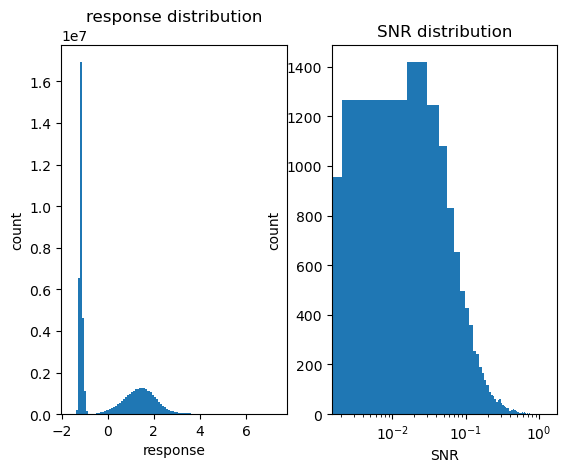

In [4]:
plt.subplot(1,2,1)
plt.hist(r.values.ravel(), bins=100)
#plt.semilogy()
plt.xlabel('response')
plt.ylabel('count')
plt.title('response distribution')
plt.subplot(1,2,2)
plt.hist(snr.ravel(), bins=100)
plt.semilogx()
plt.xlabel('SNR')
plt.ylabel('count')
plt.title('SNR distribution')

In [5]:

imgs = sio.loadmat(orig_data_dir + 'images_natimg2800_all.mat')['imgs']
left, right = rf_pos_labs[fn]
imgs = imgs[:, left:right, r.coords['stim'].values]
_ = imgs.transpose((-1,0,1))
S = _.reshape((_.shape[0], np.product(_.shape[1:])))#this gives you number images X number pixels
#PCA basis
u_im, s_im, v_im = np.linalg.svd(S, full_matrices=True)#PCA of images


In [6]:
#make gabors
img_size = 60
scales = [1, 0.5, 0.25, 0.125, ]
n_thetas = 4
thetas = np.linspace(0, 180 - 180 / n_thetas, n_thetas)
thetas = np.deg2rad(thetas)
inds = []
filters = []
for scale in tqdm(scales):
    sigma = scale * img_size / 4
    f = 1 / (scale * img_size / 2)
    steps_x = steps_y =  np.linspace(scale*img_size/2, img_size - scale*img_size/2, int(1/scale)) - img_size/2
    #increase number of steps so that there is half overlap
    if scale<1:
        steps_x = steps_y =  np.linspace(scale*img_size/2, img_size - scale*img_size/2, int(1.25/scale)) - img_size/2
    for step_x in steps_x:
        for step_y in steps_y:
            for theta in (thetas):
                for phase in [0, np.pi/2]:
                    gabor_filter = create_2d_gabor(img_size, sigma, f, theta, phase, center_x=step_x, center_y=step_y)
                    filters.append(gabor_filter)
                    inds.append(np.array([scale, step_x, step_y, theta, phase,]))
filters_gabor = np.array(filters)
gab_inds = np.array(inds)
print('number of gabors: ' + str(len(filters_gabor)))

100%|██████████| 4/4 [00:02<00:00,  1.76it/s]

number of gabors: 1040


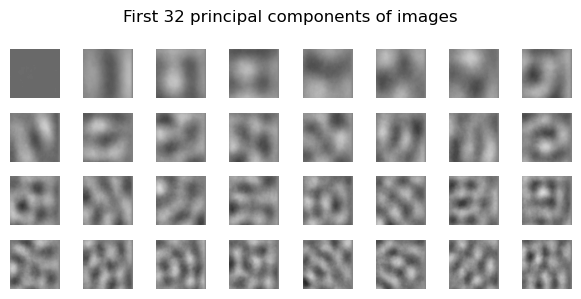

In [7]:
# Select the first 32 images
selected_images = v_im[:1024, :]

# Calculate vmin and vmax based on the minimum and maximum values across all selected images
vmin = selected_images.min()
vmax = selected_images.max()

# Create a subplot grid
num_rows = 4
num_cols = 8
s= 0.5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12*s, 6*s))

# Plot each image in the grid
for i in range(num_rows):
    for j in range(num_cols):
        index = i * num_cols + j
        if index < selected_images.shape[0]:
            # Reshape the image to its original shape (assuming it's a flattened image)
            img = selected_images[index, :].reshape(imgs.shape[:2])[:60]
            
            # Display the image in grayscale with fixed vmin and vmax
            axes[i, j].imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
            axes[i, j].axis('off')
            #axes[i, j].set_title(index+1)
plt.suptitle('First 32 principal components of images')
plt.tight_layout()
plt.show()


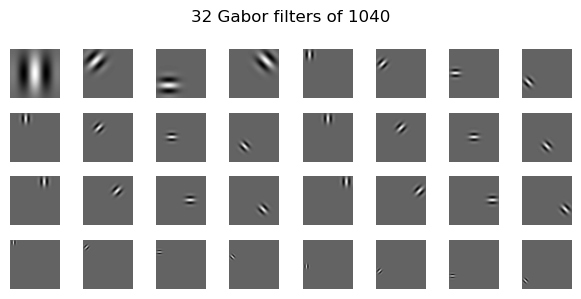

In [10]:

#make example plots of first 32 gabor filters
# Select the first 32 images
selected_images = filters_gabor[::10, :]
# Calculate vmin and vmax based on the minimum and maximum values across all selected images
vmin = selected_images.min()
vmax = selected_images.max()
# Create a subplot grid
num_rows = 4
num_cols = 8
s= 0.5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12*s, 6*s))
# Plot each image in the grid
for i in range(num_rows):
    for j in range(num_cols):
        index = i * num_cols + j
        if index < selected_images.shape[0]:
            # Reshape the image to its original shape (assuming it's a flattened image)
            img = selected_images[index]
            # Display the image in grayscale with fixed vmin and vmax
            axes[i, j].imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
            axes[i, j].axis('off')
            #axes[i, j].set_title(index+1)
plt.suptitle('32 Gabor filters of ' + str(filters_gabor.shape[0]))
plt.tight_layout()
plt.show()

In [104]:

dims = [2, 4, 8, 16, 32, 64, 128, 256, int(len(gab_inds)*2)]
filter_pc = v_im[:dims[-1],:].reshape(dims[-1], 68, 60)[:, :60]

da_neur_impc_r2 = xr.DataArray(np.zeros((n_neur, len(dims))), dims=['neur', 'dims'], coords=[range(n_neur), dims])
da_eig_impc_r2 = xr.DataArray(np.zeros((n_pcs, len(dims))), dims=['pc', 'dims'], coords=[range(n_pcs), dims])
filter_impc_resp = np.einsum('ijk,jkl->il', filter_pc, imgs[:60])
for D in tqdm(dims):
    X = filter_impc_resp[:D, :].T
    da_neur_impc_r2.loc[:,D] = noise_corr_R2(X, r.values)[0]
    da_eig_impc_r2.loc[:, D] = noise_corr_R2(X, u_r_stim[:, :n_pcs][None])[1]


da_neur_impc_squared_r2 = xr.DataArray(np.zeros((n_neur, len(dims))), dims=['neur', 'dims'], coords=[range(n_neur), dims])
da_eig_impc_squared_r2 = xr.DataArray(np.zeros((n_pcs, len(dims))), dims=['pc', 'dims'], coords=[range(n_pcs), dims])
filter_impc_squared_resp = filter_impc_resp**2
#now interleave the original and squared features
filter_resp  = []
for i in (range(0, filter_impc_resp.shape[0])):
    filter_resp.append(filter_impc_resp[i, :])
    filter_resp.append(filter_impc_squared_resp[i, :])
filter_resp = np.array(filter_resp)
for D in tqdm(dims):
    X = filter_resp[:D, :].T
    da_neur_impc_squared_r2.loc[:,D] = noise_corr_R2(X, r.values)[0]
    da_eig_impc_squared_r2.loc[:, D] = noise_corr_R2(X, u_r_stim[:, :n_pcs][None])[1]



  0%|          | 0/9 [00:00<?, ?it/s]/var/folders/b4/rkxwb4215db4_00h00gyz1xr0000gp/T/ipykernel_17741/4232210453.py:30: RuntimeWarning: Degrees of freedom <= 0 for slice
  S_var = (var_r - Y.var(0, ddof=1,).mean(0)/K)#signal variance
/Users/dean/opt/anaconda3/envs/spyder-env/lib/python3.9/site-packages/numpy/core/_methods.py:251: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
100%|██████████| 9/9 [00:42<00:00,  4.75s/it]


In [108]:

# Calculate R^2 for each neuron and eigenmode using Gabor filters as linear features
da_neur_gab_r2 = xr.DataArray(np.zeros((n_neur, len(dims))), dims=['neur', 'dims'], coords=[range(n_neur), dims])
da_eig_gab_r2 = xr.DataArray(np.zeros((n_pcs, len(dims))), dims=['pc', 'dims'], coords=[range(n_pcs), dims])
filter_gab_resp = np.einsum('ijk,jkl->il', filters_gabor, imgs[:60])
#now add one more feature of a the mean of the image
filter_gab_resp = np.concatenate((imgs[:60].mean((0,1))[None], filter_gab_resp), 0)
for D in tqdm(dims):
    X = filter_gab_resp[:D, :].T
    da_neur_gab_r2.loc[:,D] = noise_corr_R2(X, r.values)[0]
    da_eig_gab_r2.loc[:, D] = noise_corr_R2(X, u_r_stim[:, :n_pcs][None])[1]

# Calculate R^2 for each neuron and eigenmode using Gabor filters as linear features and squared features
da_neur_gab_squared_r2 = xr.DataArray(np.zeros((n_neur, len(dims))), dims=['neur', 'dims'], coords=[range(n_neur), dims])
da_eig_gab_squared_r2 = xr.DataArray(np.zeros((n_pcs, len(dims))), dims=['pc', 'dims'], coords=[range(n_pcs), dims])
filter_gab_squared_resp = filter_gab_resp[1:]**2
#now interleave the original and squared features
filter_resp  = []
for i in (range(0, filter_gab_resp.shape[0]-1)):
    filter_resp.append(filter_gab_resp[i, :])
    filter_resp.append(filter_gab_squared_resp[i, :])
filter_resp = np.array(filter_resp)

for D in tqdm(dims):
    X = filter_resp[:D, :].T
    da_neur_gab_squared_r2.loc[:,D] = noise_corr_R2(X, r.values)[0]
    da_eig_gab_squared_r2.loc[:, D] = noise_corr_R2(X, u_r_stim[:, :n_pcs][None])[1]



  0%|          | 0/9 [00:00<?, ?it/s]/var/folders/b4/rkxwb4215db4_00h00gyz1xr0000gp/T/ipykernel_17741/4232210453.py:30: RuntimeWarning: Degrees of freedom <= 0 for slice
  S_var = (var_r - Y.var(0, ddof=1,).mean(0)/K)#signal variance
/Users/dean/opt/anaconda3/envs/spyder-env/lib/python3.9/site-packages/numpy/core/_methods.py:251: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
100%|██████████| 9/9 [00:46<00:00,  5.14s/it]


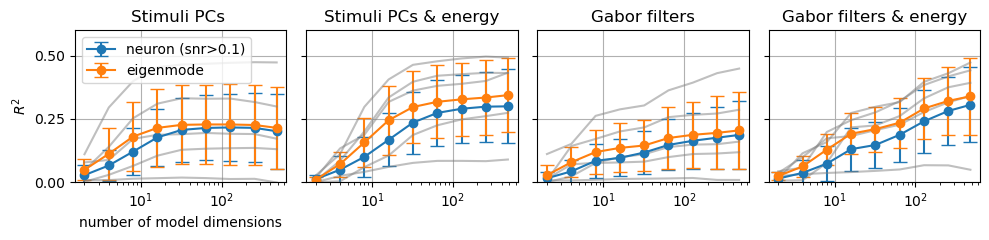

In [139]:
#make 4 plots of stimuli pcs, pcs+square, gabor, gabor+square, do all of setting ylims and ticks, and semilogx at end using a for loop
snr_thresh = 0.1
snr_mask = snr>snr_thresh
s= 0.5
fig, axes = plt.subplots(1,4, figsize=(20*s, 5*s))
show_n_pcs = 5
axes[0].errorbar(da_neur_impc_r2['dims'], da_neur_impc_r2[snr_mask].mean('neur'), yerr=da_neur_impc_r2[snr_mask].std('neur'), label='neuron (snr>' + str(snr_thresh) + ')', marker='o', capsize=5)
axes[0].errorbar(da_eig_impc_r2['dims'], da_eig_impc_r2[:show_n_pcs].mean('pc'), yerr=da_eig_impc_r2[:5].std('pc'), label='eigenmode', marker='o', capsize=5)
axes[0].plot(da_eig_impc_r2['dims'], da_eig_impc_r2[:show_n_pcs].T, color='grey', alpha=0.5)
axes[0].legend()
axes[0].set_xlabel('number of model dimensions')
axes[0].set_ylabel(r'$R^2$')
axes[0].set_title('Stimuli PCs ')

axes[1].errorbar(da_neur_impc_squared_r2['dims'], da_neur_impc_squared_r2[snr_mask].mean('neur'), yerr=da_neur_impc_squared_r2[snr_mask].std('neur'), label='neuron (snr>' + str(snr_thresh) + ')', marker='o', capsize=5)
axes[1].errorbar(da_eig_impc_squared_r2['dims'], da_eig_impc_squared_r2[:show_n_pcs].mean('pc'), yerr=da_eig_impc_squared_r2[:5].std('pc'), label='eigenmode', marker='o', capsize=5)
axes[1].plot(da_eig_impc_squared_r2['dims'], da_eig_impc_squared_r2[:show_n_pcs].T, color='grey', alpha=0.5)
axes[1].set_title('Stimuli PCs & energy')

axes[2].errorbar(da_neur_gab_r2['dims'], da_neur_gab_r2[snr_mask].mean('neur'), yerr=da_neur_gab_r2[snr_mask].std('neur'), label='neuron (snr>' + str(snr_thresh) + ')', marker='o', capsize=5)
axes[2].errorbar(da_eig_gab_r2['dims'], da_eig_gab_r2[:show_n_pcs].mean('pc'), yerr=da_eig_gab_r2[:5].std('pc'), label='eigenmode', marker='o', capsize=5)
axes[2].plot(da_eig_gab_r2['dims'], da_eig_gab_r2[:show_n_pcs].T, color='grey', alpha=0.5)
axes[2].set_title('Gabor filters')

axes[3].errorbar(da_neur_gab_squared_r2['dims'], da_neur_gab_squared_r2[snr_mask].mean('neur'), yerr=da_neur_gab_squared_r2[snr_mask].std('neur'), label='neuron (snr>' + str(snr_thresh) + ')', marker='o', capsize=5)
axes[3].errorbar(da_eig_gab_squared_r2['dims'], da_eig_gab_squared_r2[:show_n_pcs].mean('pc'), yerr=da_eig_gab_squared_r2[:5].std('pc'), label='eigenmode', marker='o', capsize=5)
axes[3].plot(da_eig_gab_squared_r2['dims'], da_eig_gab_squared_r2[:show_n_pcs].T, color='grey', alpha=0.5)
axes[3].set_title('Gabor filters & energy')

for i, ax in enumerate(axes):
    
    ax.semilogx()
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1]);ax.grid()
    ax.set_ylim([0, 0.6])
    if i==0:
        ax.legend()
    else:
        ax.legend().remove()
        ax.set_yticklabels([])
plt.tight_layout()



(0.0, 0.6)

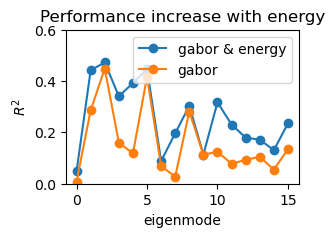

In [149]:
plt.figure(figsize=(3,2))
da_eig_gab_squared_r2[:16,-1].plot(marker='o', label='gabor & energy')
da_eig_gab_r2[:16,-1].plot(marker='o', label='gabor')
plt.legend()
plt.xlabel('eigenmode')
plt.ylabel(r'$R^2$')
plt.title('Performance increase with energy')
#replace title with better one
plt.ylim([0, 0.6])

The 2nd index here shows a jump from $R^2=0.3$ to $0.5$ when including squared terms. Lets see what its linear and quadratic filters look like. Is this jump explained by large scale quadratic filtering?

In [11]:
#make a pandas dataframe to store betas
import pandas as pd
#index = pd.MultiIndex.from_arrays(inds.T, names=['scale', 'x', 'y', 'theta', 'phase'])
#concatenate two inds together and to each append a 0 or 1 to indicate whether it is a gabor or gabor squared
# first append to inds all 0s to indicate that it is the mean
inds_gab = np.concatenate((np.zeros((1,5)), inds), 0)#add zero row to indicate that it is the mean
inds_gab = np.concatenate((inds_gab, np.zeros((inds_gab.shape[0], 1))), 1)#add zero column to indicate that it is not squared
inds_gab_squared = inds_gab[:].copy()
inds_gab_squared[:,-1] = 1
index = pd.MultiIndex.from_arrays(np.concatenate((inds_gab, inds_gab_squared)).T, names=['scale', 'x', 'y', 'theta', 'phase', 'sq'])

In [18]:
#lets get the betas for the neuron responses and the eigenmode responses in a gabor basis
filter_gab_resp = np.einsum('ijk,jkl->il', filters_gabor, imgs[:60])
filter_gab_resp = np.concatenate((imgs[:60].mean((0,1))[None], filter_gab_resp), 0)
filter_gab_squared_resp = filter_gab_resp**2
#now concatenate the original and squared features
filter_resp = np.concatenate((filter_gab_resp, filter_gab_squared_resp), 0)
#z-score the features
filter_resp = (filter_resp-filter_resp.mean(1, keepdims=True))/filter_resp.std(1, keepdims=True)
X = filter_resp.T
beta = get_beta(X, r.values)
df_neur = pd.DataFrame(beta, index=index, columns=range(n_neur))
beta = get_beta(X, u_r_stim[:, :n_pcs][None])
df_eig = pd.DataFrame(beta.squeeze(), index=index, columns=range(n_pcs))

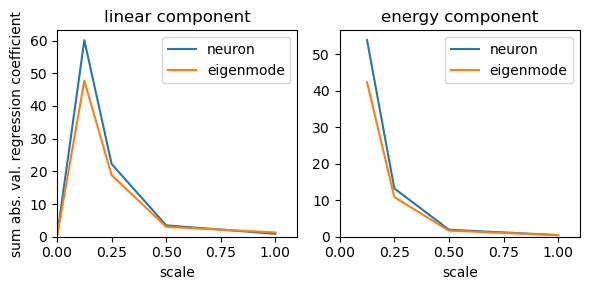

In [22]:
#grouby squared and scale
snr_thresh = 0.1
snr_mask = (snr>snr_thresh)
#convert snr_mask to indices
snr_mask = np.where(snr_mask)[0]

df_neur_sq_scale = (np.abs(df_neur.iloc[:, snr_mask])).groupby(['sq', 'scale']).sum().mean(1)
df_eig_sq_scale = (np.abs(df_eig.iloc[:,1:5])).groupby(['sq', 'scale']).sum().mean(1)
plt.figure(figsize=(6,3))
#have the same limits for both plots
for sq in [0,1]:

    plt.subplot(1,2,sq+1)
    (df_neur_sq_scale.loc[sq]).plot(label='neuron')
    (df_eig_sq_scale.loc[sq]).plot(label='eigenmode')
    plt.title(['linear', 'energy'][(sq)] + ' component')
    plt.xlim([0, 1.1])
    plt.ylim([0, None])
    plt.legend()
    if sq==0:
        plt.ylabel('sum abs. val. regression coefficient')
plt.tight_layout()

For the linear component of the response it looks like the mid scale gabors tend to have the highest magntiude weights for both eigenmodes and single neurons.
Whereas the eigenmodes tend to weight the largest scale gabors energy twice as heavily as the average neuron. 

(1040, 60, 60)
(1040, 2727)
4934


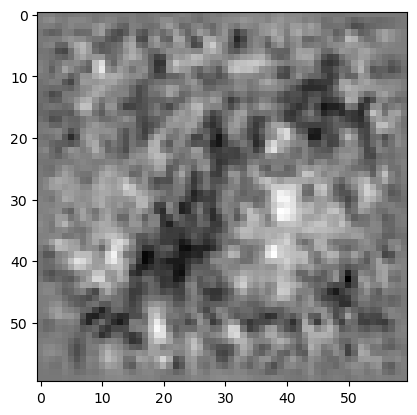

In [52]:
print(filters_gabor.shape)
print(df_neur.iloc[:1040, snr_mask].shape)
#get index of neuron with highest sum of absolute value of regression coefficients
neur_ind = df_neur.abs().sum(0).sort_values(ascending=False).index[-2]
print(neur_ind)
#reconstruct the linear filter
neur_filter = (filters_gabor*df_neur.iloc[:1040, neur_ind].values[:, None,None]).sum(0)
neur_filter.shape
plt.imshow(neur_filter, cmap='gray')

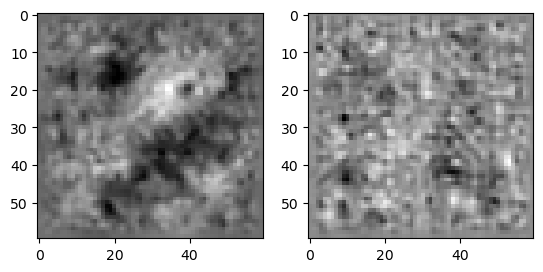

In [71]:
ind = 1
#reconstruct the linear filter of the eigenmode
eig_filter = (filters_gabor*df_eig.iloc[:1040, ind].values[:, None,None]).sum(0)
eig_filter.shape
plt.subplot(1,2,1)
plt.imshow(eig_filter, cmap='gray')

#reconstruct the linear filter of the eigenmode
plt.subplot(1,2,2)
eig_filter = (filters_gabor*df_eig.iloc[1041:, ind].values[:, None,None]).sum(0)
eig_filter.shape
plt.imshow(eig_filter, cmap='gray')

x: -22.5 y: 11.25 phase: 0.0 sq: 0.0


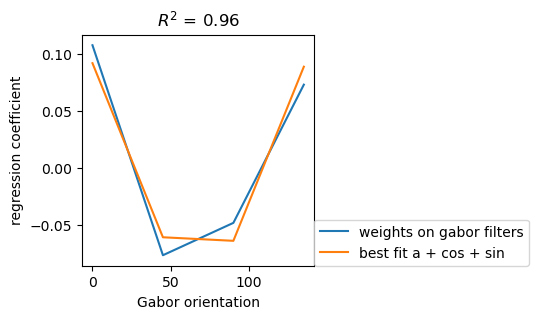

In [72]:
# for each x, y, phas, sq fit a model that is a constant plus a sin and cos term to the betas
#then report the r2 of the fit
#first iterate over all the unique x, y, phase, sq

iter_over_groups = list(iter(df_eig.iloc[:,1:5].groupby(['x', 'y', 'phase', 'sq'])))
n_groups = len(df_eig.groupby(['x', 'y', 'phase', 'sq']))
#get the first group
name, group = iter_over_groups[52]
#now fit the model
X = np.ones((group.shape[0], 3))
X[:, 1] = np.cos(thetas*2)
X[:, 2] = np.sin(thetas*2)
beta = np.linalg.lstsq(X, group.values, rcond=None)[0]
hat_weight = X @ beta
r2 = 1 - ((group.values - hat_weight)**2).sum(0)/((group.values - group.values.mean(0))**2).sum(0)
#now plot the best fit
best_ind = np.argsort(r2)[-1]
plt.figure(figsize=(3,3))
plt.plot(np.rad2deg(thetas), group.values[:, best_ind], label='weights on gabor filters')
plt.plot(np.rad2deg(thetas), hat_weight[:, best_ind], label='best fit a + cos + sin')
plt.legend(loc=(1,0))
plt.xlabel('Gabor orientation')
plt.ylabel('regression coefficient')
plt.title(r'$R^2$' ' = ' + str(np.round(r2[best_ind], 2)))
#print the name of the group, with labels
print('x: ' + str(name[0]) + ' y: ' + str(name[1]) + ' phase: ' + str(name[2]) + ' sq: ' + str(name[3]))

In [73]:
#do the basic analysis for each group returning a dataframe that has collapsed over thetas and has r^2s for each neuron
def fit_model(group):
    X = np.ones((len(thetas), 3))
    X[:, 1] = np.cos(thetas*2)
    X[:, 2] = np.sin(thetas*2)
    beta = np.linalg.lstsq(X, group.values, rcond=None)[0]
    hat_weight = X @ beta
    r2 = 1 - ((group.values - hat_weight)**2).sum(0)/((group.values - group.values.mean(0))**2).sum(0)
    return r2

#first get rid of first row of df_eig
df_eig_no_mean = df_eig.iloc[1:]
#now iterate over all the groups and fit the model
r2s = []
index = []
for name, group in tqdm(df_eig_no_mean.groupby(['scale', 'x', 'y', 'phase', 'sq'])):
    r2s.append(fit_model(group))
    index.append(name)
#now make a dataframe of the r2s
r2s = np.array(r2s)
index = pd.MultiIndex.from_tuples(index, names=['scale', 'x', 'y', 'phase', 'sq'])
df_r2_eig = pd.DataFrame(r2s, index=index)
#do the same for the neurons
df_neur_no_mean = df_neur.iloc[1:]
r2s = []
index = []
for name, group in tqdm(df_neur_no_mean.groupby(['scale', 'x', 'y', 'phase', 'sq'])):
    print(group.shape)
    r2s.append(fit_model(group))
    index.append(name)
#now make a dataframe of the r2s
r2s = np.array(r2s)
index = pd.MultiIndex.from_tuples(index, names=['scale', 'x', 'y', 'phase', 'sq'])
df_r2_neur = pd.DataFrame(r2s, index=index)

  8%|▊         | 41/520 [00:00<00:02, 196.36it/s]

(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)


 24%|██▎       | 123/520 [00:00<00:01, 329.05it/s]

(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)


 39%|███▉      | 203/520 [00:00<00:00, 367.42it/s]

(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)


 54%|█████▍    | 283/520 [00:00<00:00, 379.46it/s]

(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)


 70%|███████   | 365/520 [00:01<00:00, 394.11it/s]

(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)


 87%|████████▋ | 454/520 [00:01<00:00, 415.35it/s]

(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)


100%|██████████| 520/520 [00:01<00:00, 338.71it/s]


(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)
(4, 11445)


1         9         11        13        16        18     \
sq  scale                                                               
0.0 0.125  0.622042  0.579459  0.624420  0.614848  0.569195  0.612670   
    0.250  0.562152  0.552788  0.542433  0.534970  0.619367  0.563287   
    0.500  0.613681  0.594409  0.649155  0.444420  0.511369  0.679709   
    1.000  0.954955  0.815672  0.165031  0.762368  0.875955  0.481643   
1.0 0.125  0.652321  0.613781  0.639419  0.616475  0.617321  0.675180   
    0.250  0.736156  0.634200  0.619774  0.600887  0.627231  0.738944   
    0.500  0.619605  0.736932  0.610177  0.718193  0.708987  0.468209   
    1.000  0.862910  0.772741  0.804308  0.554965  0.369134  0.526242   

              19        22        34        36     ...     11335     11346  \
sq  scale                                          ...                       
0.0 0.125  0.578528  0.562776  0.556776  0.573123  ...  0.560279  0.595654   
    0.250  0.552450  0.513657  0.559686  0.584244  ...  0.453228  0.480845   
    0.500  0.594042  0.557482  0.474893  0.644430  ...  0.537925  0.653389   
    1.000  0.482818  0.853025  0.980715  0.705502  ...  0.661118  0.515710   
1.0 0.125  0.659118  0.592237  0.617103  0.628450  ...  0.634794  0.631454   
    0.250  0.680892  0.670403  0.602495  0.628235  ...  0.584106  0.632001   
    0.500  0.786500  0.571597  0.668144  0.459461  ...  0.648198  0.656209   
    1.000  0.611039  0.990387  0.662883  0.627687  ...  0.577994  0.615098   

              11351     11357     11358     11363     11383     11393  \
sq  scale                                                               
0.0 0.125  0.575852  0.571521  0.574248  0.572991  0.615964  0.616101   
    0.250  0.514141  0.525053  0.526769  0.579598  0.486634  0.530797   
    0.500  0.577843  0.617751  0.601201  0.669613  0.727427  0.538278   
    1.000  0.382903  0.105482  0.541640  0.523503  0.937424  0.502506   
1.0 0.125  0.621054  0.659451  0.625292  0.633195  0.647718  0.649886   
    0.250  0.637581  0.575873  0.692059  0.580190  0.567866  0.638015   
    0.500  0.765691  0.714433  0.450027  0.426243  0.791647  0.619649   
    1.000  0.661775  0.481175  0.615677  0.926226  0.662587  0.484910   

              11418     11441  
sq  scale                      
0.0 0.125  0.588143  0.610543  
    0.250  0.511673  0.555152  
    0.500  0.505637  0.676062  
    1.000  0.205471  0.302401  
1.0 0.125  0.694392  0.678008  
    0.250  0.666303  0.587227  
    0.500  0.509304  0.820278  
    1.000  0.713176  0.343502  

[8 rows x 2727 columns]

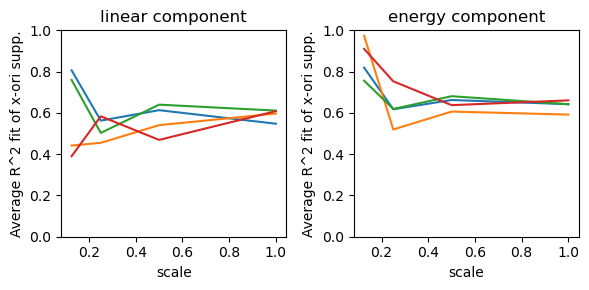

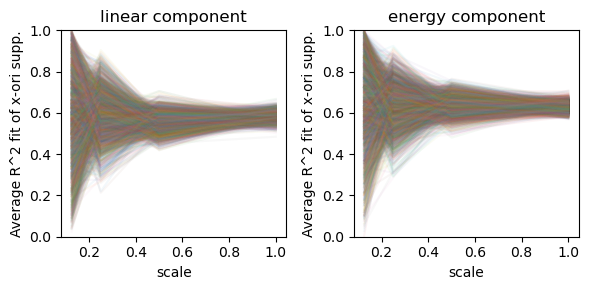

In [74]:
#now analyze df_r2 to compare scales and energy vs linear
#first groupby scale and sq
df_r2_scale_sq = df_r2_eig.iloc[:,1:5].groupby([ 'sq', 'scale',]).mean()
#now make a plot of the r2s for each scale and phase
plt.figure(figsize=(6,3))
for sq in [0,1]:
    plt.subplot(1,2,sq+1)
    r2 = df_r2_scale_sq.loc[sq].values
    plt.plot(scales, r2)
    plt.title(['linear', 'energy'][sq] + ' component')
    plt.ylabel('mean r2')
    plt.ylabel('Average R^2 fit of x-ori supp.')
    plt.xlabel('scale')
    plt.ylim(0,1)
plt.tight_layout()
#now analyze df_r2 to compare scales and energy vs linear
#first groupby scale and sq
df_r2_scale_sq = df_r2_neur.iloc[:,snr_mask].groupby([ 'sq', 'scale',]).mean()
#now make a plot of the r2s for each scale and phase

plt.figure(figsize=(6,3))
for sq in [0,1]:
    plt.subplot(1,2,sq+1)
    r2 = df_r2_scale_sq.loc[sq].values
    plt.plot(scales, r2, alpha=0.05)
    plt.title(['linear', 'energy'][sq] + ' component')
    plt.ylabel('mean r2')
    plt.ylabel('Average R^2 fit of x-ori supp.')
    plt.xlabel('scale')
    plt.ylim(0,1)
plt.tight_layout()
df_r2_scale_sq

x       y         
-26.25  -26.250000    0.638553
        -20.416667    0.649705
        -14.583333    0.060810
        -8.750000     0.562958
        -2.916667     0.285593
                        ...   
 26.25   2.916667     0.285167
         8.750000     0.817551
         14.583333    0.636514
         20.416667    0.817993
         26.250000    0.888104
Name: 2, Length: 100, dtype: float64

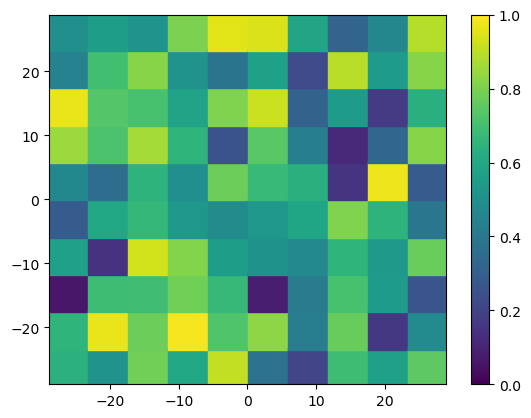

In [117]:
v = df_r2_eig.loc[0.125, 2].groupby(['sq', 'x', 'y', ]).mean().loc[1]
x = v.index.get_level_values('x')
y = v.index.get_level_values('y')
plt.scatter(x, y, c=v.values, cmap='viridis',s=800, vmin=0, vmax=1, marker='s')
plt.colorbar()
v


0         1         2         3   \
scale x      y          phase    sq                                            
0.125 -26.25 -26.250000 0.000000 0.0  0.919665  0.435171  0.455056  0.608129   
                                 1.0  0.806014  0.587422  0.361838  0.832599   
                        1.570796 0.0  0.781517  0.479485  0.266269  0.993089   
                                 1.0  0.659384  0.963514  0.915268  0.956720   
             -20.416667 0.000000 0.0  0.802010  0.975301  0.032082  0.396329   
...                                        ...       ...       ...       ...   
0.500  15.00  15.000000 1.570796 1.0  0.650416  0.986762  0.017443  0.471125   
1.000  0.00   0.000000  0.000000 0.0  0.008911  0.632728  0.724214  0.683296   
                                 1.0  0.885154  0.646089  0.996180  0.985231   
                        1.570796 0.0  0.897715  0.979898  0.158991  0.835613   
                                 1.0  0.907227  0.992141  0.951343  0.526629   

                                            4         5         6         7   \
scale x      y          phase    sq                                            
0.125 -26.25 -26.250000 0.000000 0.0  0.902220  0.967544  0.639791  0.930957   
                                 1.0  0.897945  0.120064  0.987445  0.882062   
                        1.570796 0.0  0.905582  0.148625  0.169879  0.465351   
                                 1.0  0.414217  0.439725  0.969760  0.891344   
             -20.416667 0.000000 0.0  0.939027  0.593279  0.016170  0.486536   
...                                        ...       ...       ...       ...   
0.500  15.00  15.000000 1.570796 1.0  0.850765  0.928381  0.548041  0.574335   
1.000  0.00   0.000000  0.000000 0.0  0.778028  0.265033  0.095675  0.370037   
                                 1.0  0.846657  0.813583  0.974598  0.268014   
                        1.570796 0.0  0.002319  0.805361  0.292572  0.526387   
                                 1.0  0.973410  0.364728  0.094080  0.923822   

                                            8         9   ...        22  \
scale x      y          phase    sq                       ...             
0.125 -26.25 -26.250000 0.000000 0.0  0.032583  0.405465  ...  0.595912   
                                 1.0  0.218595  0.921693  ...  0.584199   
                        1.570796 0.0  0.874760  0.352900  ...  0.286472   
                                 1.0  0.719753  0.999819  ...  0.973941   
             -20.416667 0.000000 0.0  0.287686  0.126785  ...  0.941094   
...                                        ...       ...  ...       ...   
0.500  15.00  15.000000 1.570796 1.0  0.717838  0.450610  ...  0.842853   
1.000  0.00   0.000000  0.000000 0.0  0.304965  0.104219  ...  0.500708   
                                 1.0  0.332742  0.333767  ...  0.236125   
                        1.570796 0.0  0.771260  0.110050  ...  0.126171   
                                 1.0  0.825175  0.867066  ...  0.340394   

                                            23        24        25        26  \
scale x      y          phase    sq                                            
0.125 -26.25 -26.250000 0.000000 0.0  0.574750  0.094126  0.669896  0.168584   
                                 1.0  0.088799  0.053057  0.895157  0.963862   
                        1.570796 0.0  0.462248  0.719548  0.967279  0.963626   
                                 1.0  0.274783  0.998750  0.295223  0.576124   
             -20.416667 0.000000 0.0  0.020076  0.785595  0.925066  0.737980   
...                                        ...       ...       ...       ...   
0.500  15.00  15.000000 1.570796 1.0  0.684295  0.677336  0.999917  0.259855   
1.000  0.00   0.000000  0.000000 0.0  0.658178  0.966132  0.000968  0.995123   
                                 1.0  0.992213  0.771898  0.237750  0.378922   
                        1.570796 0.0  0.273616  0.859352  0.675094  0.992698   
                          

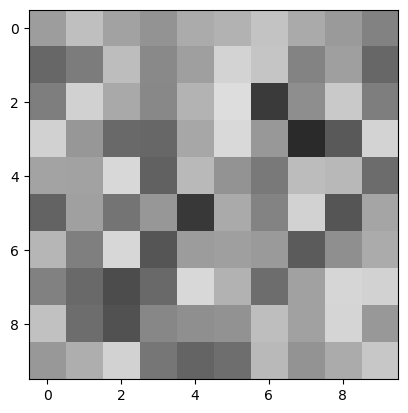

In [111]:

x = (df_r2_eig.index.get_level_values('x')).argsort()
y = np.unique(df_r2_eig.index.get_level_values('y'))
#now make a grid
X, Y = np.meshgrid(x, y)
#now reshape the r2s
r2 = v.values.reshape((10,10))
plt.imshow(r2, vmin=0, vmax=1, cmap='gray')
df_r2_eig


In [ ]:

#now get the r2 values
r2 = df_r2_eig.loc[0.125].groupby(['x', 'y']).mean().values
#now make an image grid
r2_grid = np.zeros((len(x), len(y)))
for i, x_ in enumerate(x):
    for j, y_ in enumerate(y):
        r2_grid[i, j] = r2[(x==x_) & (y==y_)]
plt.imshow(r2_grid, cmap='gray')


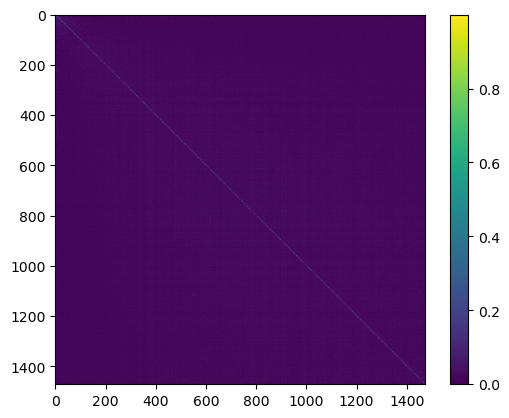

In [92]:
#plot the correflation matrix of the features
R = np.abs(np.corrcoef(filter_resp))
#set digaonal to zero
R = R - np.diag(np.diag(R))
plt.imshow(R)
plt.colorbar()

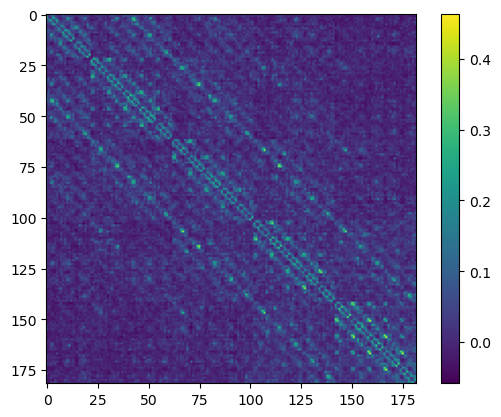

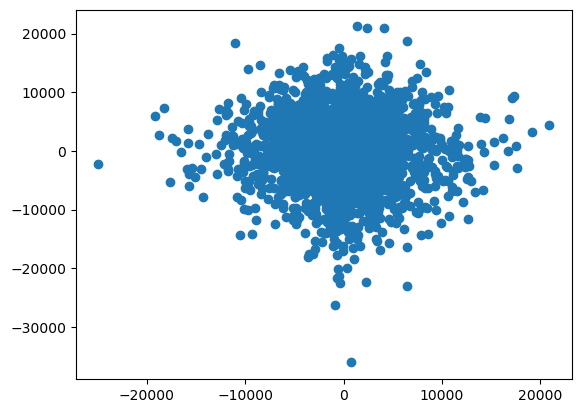

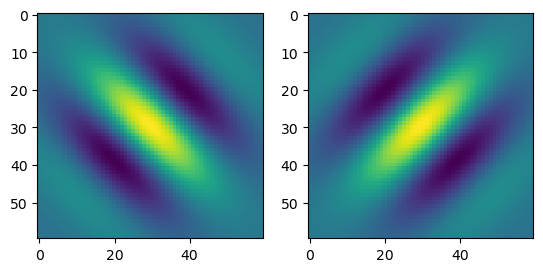

In [101]:
#get response across images for first two gabors
filter_gab_resp = np.einsum('ijk,jkl->il', filters_gabor, imgs[:60])
filter_gab_resp = np.concatenate((imgs[:60].mean((0,1))[None], filter_gab_resp), 0)
#now concatenate the original and squared features
filter_gab_resp = np.concatenate((filter_gab_resp, filter_gab_resp**2), 0)

#get correlation matrix of filter responses
R = np.corrcoef(filter_gab_resp)
#set diagonal to zero
R = R - np.diag(np.diag(R))
plt.imshow(R[300:,300:])
plt.colorbar()
plt.figure()
i=6
j=2
plt.scatter(filter_gab_resp[i], filter_gab_resp[j])
plt.figure()
#now show the two gabors
plt.subplot(1,2,1)
plt.imshow(filters_gabor[i])
plt.subplot(1,2,2)
plt.imshow(filters_gabor[j])


In [235]:
tagged_fns = ['ms_natimg2800_M170714_MP032_2017-08-07',
              'ms_natimg2800_M170604_MP031_2017-06-28', 
             'ms_natimg2800_M170714_MP032_2017-09-14', ]#these are the files with tdtomato tags
crit_p = 0.001
n_eig_vecs = 20
inds = [[1,21], [22, 42], [43, 63]]
k = 0
fn = tagged_fns[k]
red_cell = pd.read_csv(data_dir + 'processed_data/red_cell/' + fn[3:] + '.csv', index_col=0)
red_cell = red_cell.values.squeeze().astype(bool)
v_r = np.load(eig_tuning_dir + 'sp_cov_neur_u_r_' + fn + '.npy', )

In [292]:
#try a a linear classifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
log_reg = LogisticRegression(class_weight='balanced')
n_eig_vecs=10
scores = cross_val_score(log_reg, v_r[:, :n_eig_vecs], red_cell.astype(int), cv=5, scoring='precision')
print('logistic regression accuracy = ' + str(np.round(scores.mean(), 2)))
#get the average weights for the logistic regression
log_reg.fit(v_r[:, :n_eig_vecs], red_cell.astype(int))
#now predict
pred = log_reg.predict(v_r[:, :n_eig_vecs])
#calculate the precision using pred
tp = np.mean(pred == red_cell.astype(int))
fp = np.mean(pred[~red_cell.astype(bool)] == 1)

logistic regression accuracy = 0.28


array([0, 1, 0, ..., 0, 0, 0])

In [283]:
#try k nearest neighbors
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
n_eig_vecs =20
scores = cross_val_score(knn, v_r[:, :n_eig_vecs], red_cell.astype(int), cv=5, scoring='precision')


/Users/dean/opt/anaconda3/envs/spyder-env/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/dean/opt/anaconda3/envs/spyder-env/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

In [284]:
print('knn accuracy = ' + str(np.round(scores.mean(), 2)))

knn accuracy = 0.49


In [287]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
#convert the red_cell to ints
red_cell_int = red_cell.astype(int)
import matplotlib.pyplot as plt
n_eig_vecs_range = range(1, 100)
log_reg_scores = []
knn_scores = []

for n in n_eig_vecs_range:
    log_reg = LogisticRegression(class_weight='balanced')
    knn = KNeighborsClassifier()
    
    log_reg_scores.append(cross_val_score(log_reg, v_r[:, :n], red_cell_int, cv=5, scoring='precision').mean())
    knn_scores.append(cross_val_score(knn, v_r[:, :n], red_cell_int, cv=5, scoring='precision').mean())


/Users/dean/opt/anaconda3/envs/spyder-env/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/dean/opt/anaconda3/envs/spyder-env/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and t

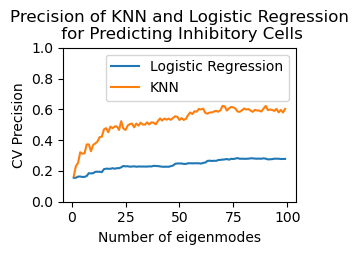

In [291]:
plt.figure(figsize=(3,2))
plt.plot(n_eig_vecs_range, log_reg_scores, label='Logistic Regression')
plt.plot(n_eig_vecs_range, knn_scores, label='KNN')
plt.xlabel('Number of eigenmodes')
plt.ylabel('CV Precision')
plt.title('Precision of KNN and Logistic Regression\n for Predicting Inhibitory Cells')
plt.ylim(0,1)
plt.legend()
plt.show()


In [44]:

dims = [2, 4, 8, 16, 32, 256, 512]
dims = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
filter_pc = v_im[:dims[-1],:].reshape(dims[-1], 68, 60)[:, :60]

# da_neur_impc_r2 = xr.DataArray(np.zeros((n_neur, len(dims))), dims=['neur', 'dims'], coords=[range(n_neur), dims])
# da_eig_impc_r2 = xr.DataArray(np.zeros((n_pcs, len(dims))), dims=['pc', 'dims'], coords=[range(n_pcs), dims])
#update the data arrays so they can store the r2 results for the three different types of features
da_neur_impc_r2 = xr.DataArray(np.zeros((n_neur, len(dims), 3)), dims=['neur', 'dims', 'feature'], coords=[range(n_neur), dims, ['linear', 'energy', 'relu']])
da_eig_impc_r2 = xr.DataArray(np.zeros((n_pcs, len(dims), 3)), dims=['pc', 'dims', 'feature'], coords=[range(n_pcs), dims, ['linear', 'energy', 'relu']])
filter_impc_resp = np.einsum('ijk,jkl->il', filter_pc, imgs[:60])
#now get the sign flipped version
filter_impc_resp_neg = filter_impc_resp*-1
#filter_impc_resp_all = np.array([np.concatenate([filter_impc_resp[i:i+1], filter_impc_resp_neg[i:i+1]]) for i in range(filter_impc_resp_neg.shape[0])])
# the commented code above does not work make sure that in the end you get feature X number image responses
filter_impc_resp_all = np.zeros((filter_impc_resp.shape[0]*2, filter_impc_resp.shape[1]))
filter_impc_resp_all[::2] = filter_impc_resp
filter_impc_resp_all[1::2] = filter_impc_resp_neg
#now rectify the responses
filter_impc_resp_all[filter_impc_resp_all<0] = 0
relu = filter_impc_resp_all.copy()

#now try the same thing but with the squared responses
filter_impc_resp_squared = filter_impc_resp**2
#concatenate the squared responses with the original responses
filter_impc_resp_all = np.zeros((filter_impc_resp.shape[0]*2, filter_impc_resp.shape[1]))
filter_impc_resp_all[::2] = filter_impc_resp
filter_impc_resp_all[1::2] = filter_impc_resp_squared
energy = filter_impc_resp_all.copy()

lineaer = filter_impc_resp.copy()




In [45]:
#now go through features and dimensions and calculate r2 and store in data array
for D in tqdm(dims):
    X = filter_impc_resp[:D, :].T
    da_neur_impc_r2.loc[:,D, 'linear'] = noise_corr_R2(X, r.values)[0]
    da_eig_impc_r2.loc[:, D, 'linear'] = noise_corr_R2(X, u_r_stim[:, :n_pcs][None])[1]
    
    X = energy[:D, :].T
    da_neur_impc_r2.loc[:,D, 'energy'] = noise_corr_R2(X, r.values)[0]
    da_eig_impc_r2.loc[:, D, 'energy'] = noise_corr_R2(X, u_r_stim[:, :n_pcs][None])[1]
    
    X = relu[:D, :].T
    da_neur_impc_r2.loc[:,D, 'relu'] = noise_corr_R2(X, r.values)[0]
    da_eig_impc_r2.loc[:, D, 'relu'] = noise_corr_R2(X, u_r_stim[:, :n_pcs][None])[1]



  0%|          | 0/10 [00:00<?, ?it/s]/var/folders/b4/rkxwb4215db4_00h00gyz1xr0000gp/T/ipykernel_26564/1165660418.py:55: RuntimeWarning: Degrees of freedom <= 0 for slice
  S_var = (var_r - Y.var(0, ddof=1,).mean(0)/K)#signal variance
/Users/dean/opt/anaconda3/envs/spyder-env/lib/python3.9/site-packages/numpy/core/_methods.py:251: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
100%|██████████| 10/10 [03:18<00:00, 19.80s/it]


(0.0, 1.0)

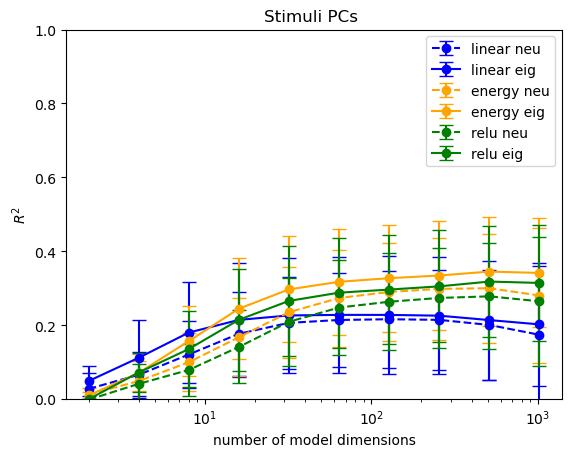

In [49]:
show_n_pcs = 5

#plots the errorbars for the three different features
plt.figure()
colors = ['blue', 'orange', 'green']
for i, feature in enumerate(['linear', 'energy', 'relu']):
    plt.errorbar(da_neur_impc_r2['dims'], da_neur_impc_r2[snr_mask].mean('neur')[..., i], yerr=da_neur_impc_r2[snr_mask].std('neur')[..., i], label=feature + ' neu', marker='o', capsize=5, ls='--', c=colors[i])
    plt.errorbar(da_eig_impc_r2['dims'], da_eig_impc_r2[:show_n_pcs].mean('pc')[..., i], yerr=da_eig_impc_r2[:show_n_pcs].std('pc')[..., i], label=feature + ' eig', marker='o', capsize=5, c=colors[i])
plt.legend()
plt.xlabel('number of model dimensions')
plt.ylabel(r'$R^2$')
plt.title('Stimuli PCs ')
plt.semilogx()
plt.ylim([0, 1])


In [78]:
n_pcs_stim = 100
n_pcs_resp = 10
filter_impc_resp = np.einsum('ijk,jkl->il', filter_pc[:n_pcs_stim], imgs[:60])
filter_impc_resp_neg = filter_impc_resp*-1
filter_impc_resp_all = np.concatenate([filter_impc_resp, filter_impc_resp_neg], 0)
filter_impc_resp_all[filter_impc_resp_all<0] = 0
relu = filter_impc_resp_all.copy()
beta_eig = get_beta(relu.T, u_r_stim[:, :n_pcs_resp][None])


In [79]:
print(beta_eig.shape)
print(filters_gabor.shape)
print(filter_pc[:n_pcs].shape)


(200, 10)
(1040, 60, 60)
(32, 60, 60)


In [92]:
i = 1
eig_filter_pos = (filter_pc[:n_pcs_stim]*beta_eig.squeeze()[:len(filter_pc[:n_pcs_stim]), None,None, i]).sum(0)
eig_filter_neg = (filter_pc[:n_pcs_stim]*beta_eig.squeeze()[len(filter_pc[:n_pcs_stim]):, None,None, i]).sum(0)

plt.subplot(1,2,1)
plt.imshow(eig_filter_pos, cmap='gray')

#reconstruct the linear filter of the eigenmode
plt.subplot(1,2,2)
plt.imshow(eig_filter_neg, cmap='gray')

ValueError: operands could not be broadcast together with shapes (100,60,60) (0,1,1) 

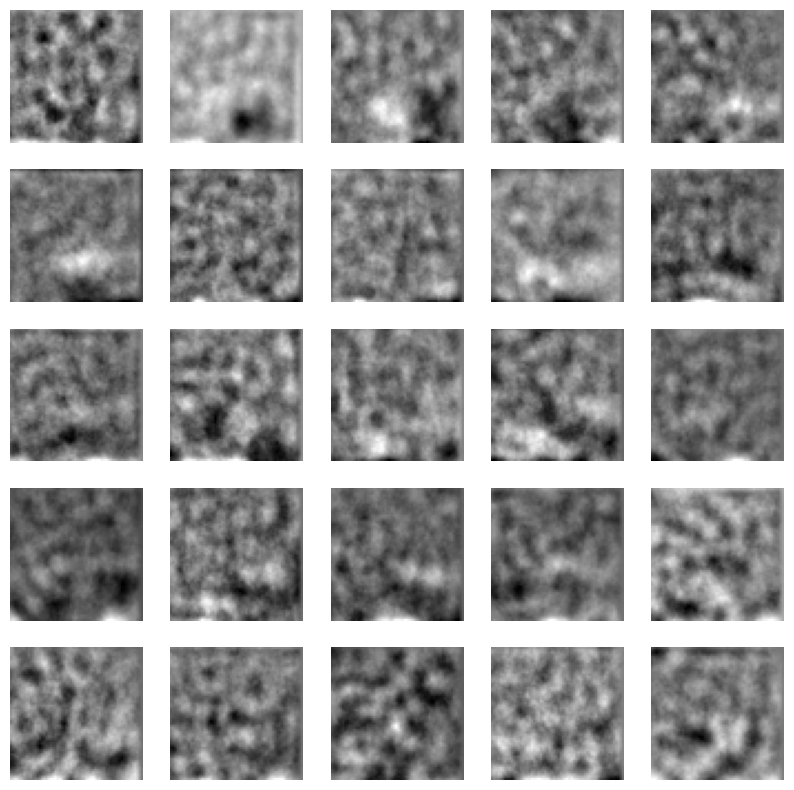

In [105]:
#visualize just fitting a linear filter to the first 10 eigenmodes
i = 5

n_eig_vecs = 500
beta_eig = get_beta(filter_impc_resp.T, u_r_stim[:, :n_eig_vecs][None])
eig_filter = (filter_pc[:n_pcs_stim, ..., None]*beta_eig.squeeze()[:, None,None, :]).sum(0)
#now show all the filters in a grid
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(eig_filter[..., i], cmap='gray')
    plt.axis('off')


In [34]:

# Define the x-axis values
x = dims
snr = hat_snr(r.values)[1]
snr_thresh = 0.1
snr_mask = snr>snr_thresh


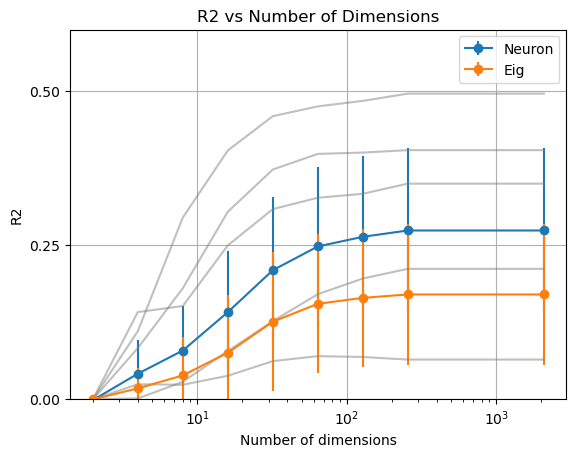

In [36]:

# Define the y-axis values and error bars for neuron and eig
y_neuron = da_neur_impc_r2.loc[snr_mask].mean(dim='neur').values
y_eig = da_eig_impc_r2.mean(dim='pc').values
error_neuron = da_neur_impc_r2.loc[snr_mask].std(dim='neur').values
error_eig = da_eig_impc_r2.std(dim='pc').values

# Plot the results
plt.errorbar(x, y_neuron, yerr=error_neuron, label='Neuron', marker='o')
plt.errorbar(x, y_eig, yerr=error_eig, label='Eig', marker='o')
#plot individual eigenmodes for 1-5
plt.plot(x, da_eig_impc_r2[:5].T, color='grey', alpha=0.5)

# Add labels and title
plt.xlabel('Number of dimensions')
plt.ylabel('R2')
plt.title('R2 vs Number of Dimensions')
plt.yticks([0, 0.25, 0.5, 0.75, 1]);plt.grid()
plt.ylim([0, 0.6])
# Add legend
plt.legend()
plt.semilogx()
# Show the plot
plt.show()


NameError: name 'da_eig_gab_squared_r2' is not defined

<Figure size 300x200 with 0 Axes>